# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

**Ник на kaggle Михаил_Филимонов_570516545**

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import PIL
print(PIL.__version__)

9.5.0


In [4]:
!ls /kaggle/input/simpsons/train

simpsons_dataset


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 12 11:40:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [9]:
from torchvision import datasets
TRAIN_DIR = Path("/kaggle/input/simpsons/train/simpsons_dataset")
TEST_DIR = Path("/kaggle/input/simpsons/testset/testset")
BATCH_SIZE = 256
RESCALE_SIZE = 224

In [10]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [12]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2)

100%|██████████| 20933/20933 [02:54<00:00, 120.16it/s]


In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

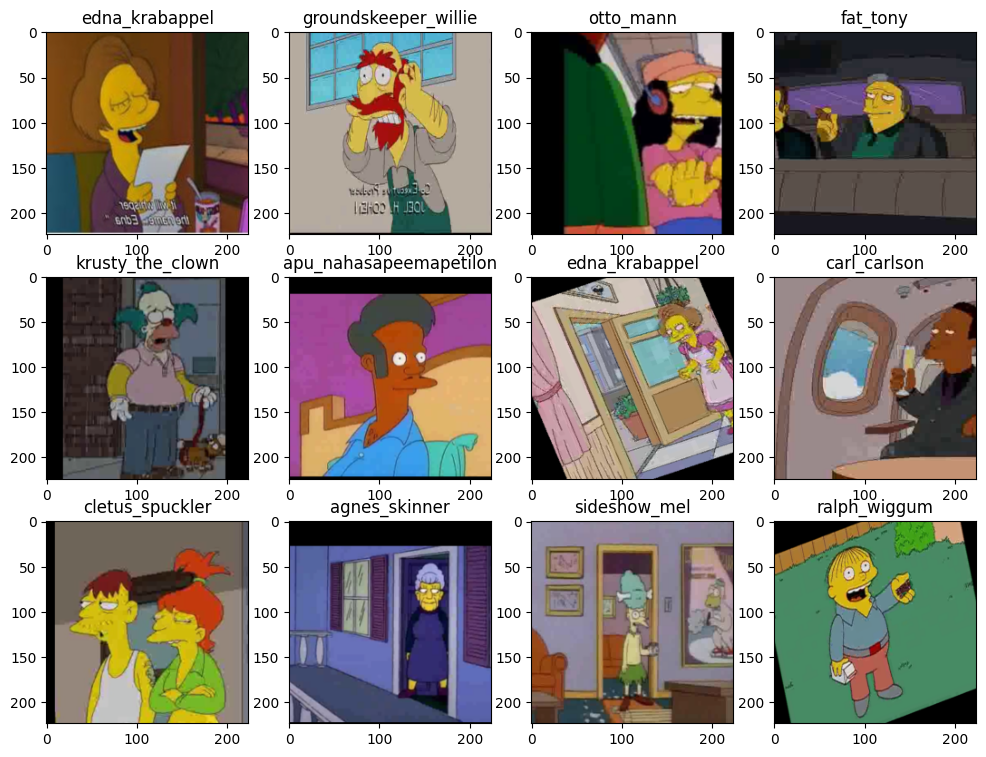

In [14]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

Давайте посмотрим на наших героев внутри датасета.

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [18]:
n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=2400, out_features=n_classes),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6):

In [19]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model[6] = nn.Sequential(
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
)
model.append(nn.Sequential(
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
))
model.append(nn.Linear(in_features=4096, out_features=n_classes, bias=True))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Sequential(
    (0): Linear(in_fea

In [22]:
model = model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   5%|▌         | 1/20 [04:43<1:29:39, 283.14s/it]


Epoch 001 train_loss: 1.7757 train_acc 0.5168


epoch:  10%|█         | 2/20 [09:34<1:26:25, 288.08s/it]


Epoch 002 train_loss: 0.4458 train_acc 0.8731


epoch:  15%|█▌        | 3/20 [14:20<1:21:17, 286.91s/it]


Epoch 003 train_loss: 0.2443 train_acc 0.9281


epoch:  20%|██        | 4/20 [19:42<1:20:17, 301.07s/it]


Epoch 004 train_loss: 0.1695 train_acc 0.9495


epoch:  25%|██▌       | 5/20 [24:37<1:14:39, 298.66s/it]


Epoch 005 train_loss: 0.1241 train_acc 0.9628


epoch:  30%|███       | 6/20 [29:59<1:11:32, 306.62s/it]


Epoch 006 train_loss: 0.0967 train_acc 0.9710


epoch:  35%|███▌      | 7/20 [35:11<1:06:49, 308.44s/it]


Epoch 007 train_loss: 0.0781 train_acc 0.9767


epoch:  40%|████      | 8/20 [40:08<1:00:55, 304.62s/it]


Epoch 008 train_loss: 0.0364 train_acc 0.9894


epoch:  45%|████▌     | 9/20 [45:08<55:35, 303.27s/it]  


Epoch 009 train_loss: 0.0263 train_acc 0.9926


epoch:  50%|█████     | 10/20 [49:56<49:44, 298.47s/it]


Epoch 010 train_loss: 0.0217 train_acc 0.9938


epoch:  55%|█████▌    | 11/20 [54:43<44:16, 295.20s/it]


Epoch 011 train_loss: 0.0188 train_acc 0.9948


epoch:  60%|██████    | 12/20 [59:48<39:44, 298.12s/it]


Epoch 012 train_loss: 0.0160 train_acc 0.9953


epoch:  65%|██████▌   | 13/20 [1:04:46<34:46, 298.04s/it]


Epoch 013 train_loss: 0.0137 train_acc 0.9962


epoch:  70%|███████   | 14/20 [1:09:30<29:22, 293.77s/it]


Epoch 014 train_loss: 0.0118 train_acc 0.9966


epoch:  75%|███████▌  | 15/20 [1:14:46<25:02, 300.56s/it]


Epoch 015 train_loss: 0.0113 train_acc 0.9968


epoch:  80%|████████  | 16/20 [1:19:30<19:42, 295.55s/it]


Epoch 016 train_loss: 0.0127 train_acc 0.9965


epoch:  85%|████████▌ | 17/20 [1:24:12<14:34, 291.40s/it]


Epoch 017 train_loss: 0.0111 train_acc 0.9970


epoch:  90%|█████████ | 18/20 [1:29:17<09:50, 295.49s/it]


Epoch 018 train_loss: 0.0099 train_acc 0.9972


epoch:  95%|█████████▌| 19/20 [1:34:03<04:52, 292.61s/it]


Epoch 019 train_loss: 0.0100 train_acc 0.9970


epoch: 100%|██████████| 20/20 [1:39:14<00:00, 297.74s/it]


Epoch 020 train_loss: 0.0110 train_acc 0.9971


In [24]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [27]:
import pandas as pd
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("baseline_aug.csv", index=False)
base_line = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
base_line
base_line.to_csv("/kaggle/working/baseline_aug.csv", index=False)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [37]:
torch.save(model.state_dict(), Path("/kaggle/working/my_model"))